In [63]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.autograd import Variable
import torchvision
import os
import random

In [65]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import matplotlib.pyplot as plt # data visualization library
import sklearn
from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.extmath import randomized_svd

# Exercise : Convolution Neural Network

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
# Download data and define the transformer (data normalization)
# Do not change this function
def load_data(seed_value=42):
    MNIST_normalize = transforms.Normalize((0.1307,), (0.3081,))
    MNIST_transform = transforms.Compose([
      transforms.ToTensor(),
      MNIST_normalize
    ])

    # MNIST Dataset
    train = datasets.MNIST(root='./data/',
                                train=True,
                                transform=MNIST_transform,
                                download=True)

    test = datasets.MNIST(root='./data/',
                                train=False,
                                transform=MNIST_transform)

    #print(valid.dataset.data.shape)
    train_subset_size = 5000
    train.data = train.data[0:train_subset_size]
    train.targets = train.targets[0:train_subset_size]

    train_size = int(0.9 * train_subset_size)
    val_size =  int(0.1 * train_subset_size)
    print("train_set_size:", train_size)
    print("val_set_size:", val_size)

    train, valid = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(seed_value))

    return train, valid, test

In [6]:
# Function to show data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
# Data Loader 
def get_data_loaders(dataset, batch_size, shuffle=True):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=shuffle)
    return loader

In [8]:
# Model
class Conv_Net(nn.Module):
    def __init__(self, dropout_value=0.5):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3)
        self.mp = nn.MaxPool2d(2)
        self.drop = nn.Dropout(dropout_value)
        self.fc = nn.Linear(6400, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.drop(x)
        x = self.fc(x)
        return F.log_softmax(x)

In [9]:
# Run one training epoch
def train(epoch, train_loader, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


In [10]:
# Compute metrics
def test(test_loader, device, is_train_set=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = Variable(data).to(device), Variable(target).to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).data
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        'Train evaluation' if is_train_set else 'Val/Test evaluation', test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Execution with default hyperparameters (A & B)

In [11]:
# Use the default seed
seed_everything(seed=42)

# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.0
dropout_value = 0.0
num_epochs = 15

# Select the device
# device = 'cuda'
device = 'cpu'

# Define the network
model = Conv_Net(dropout_value).to(device)

# Define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

# Divide the available data into training and validation datasets
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)

# Run the training epochs
for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)

# Compute the metrics using the testing dataset
test(test_loader, device, is_train_set=False)

train_set_size: 4500
val_set_size: 500


/tmp/ipykernel_374010/1825828453.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/4500 (0%)]	Loss: 2.338832
Train Epoch: 1 [1280/4500 (28%)]	Loss: 3.472321
Train Epoch: 1 [2560/4500 (56%)]	Loss: 1.623175
Train Epoch: 1 [3840/4500 (83%)]	Loss: 0.983370


/home/jesse/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Train evaluation: Average loss: 0.4743, Accuracy: 3900/4500 (87%)


Val/Test evaluation: Average loss: 0.5752, Accuracy: 420/500 (84%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 0.411375
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.435883
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.445037
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.249387

Train evaluation: Average loss: 0.3354, Accuracy: 4099/4500 (91%)


Val/Test evaluation: Average loss: 0.4345, Accuracy: 435/500 (87%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.390188
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.454970
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.087253
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.209232

Train evaluation: Average loss: 0.2172, Accuracy: 4206/4500 (93%)


Val/Test evaluation: Average loss: 0.3717, Accuracy: 442/500 (88%)

Train Epoch: 4 [0/4500 (0%)]	Loss: 0.175068
Train Epoch: 4 [1280/4500 (28%)]	Loss: 0.269954
Train Epoch: 4 [2560/4500 (56%)]	Loss: 0.502989
Train Epoch: 4 [3840/4500 (83%)]	Loss: 0.049476

Train evaluation: Averag

# Execution for C

Notes: Increasing dropout to 0.5 provides a better result than the default hyperparams. Accuracy is 1% higher, and the loss goes from 0.27 to 0.08. It likely generalizes better with this change and therefore prevents overfitting of the test data. It is also MASSIVELY ACCURATE on the training data with an accuracy of 99%.

In [12]:
# Use the default seed
seed_everything(seed=42)

# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.0
dropout_value = 0.5
num_epochs = 15

# Select the device
# device = 'cuda'
device = 'cpu'

# Define the network
model = Conv_Net(dropout_value).to(device)

# Define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

# Divide the available data into training and validation datasets
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)

# Run the training epochs
for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)

# Compute the metrics using the testing dataset
test(test_loader, device, is_train_set=False)

train_set_size: 4500
val_set_size: 500


/tmp/ipykernel_374010/1825828453.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/4500 (0%)]	Loss: 2.323755
Train Epoch: 1 [1280/4500 (28%)]	Loss: 2.033399
Train Epoch: 1 [2560/4500 (56%)]	Loss: 1.359206
Train Epoch: 1 [3840/4500 (83%)]	Loss: 1.064032

Train evaluation: Average loss: 0.9001, Accuracy: 3448/4500 (77%)


Val/Test evaluation: Average loss: 1.0980, Accuracy: 366/500 (73%)

Train Epoch: 2 [0/4500 (0%)]	Loss: 1.494861
Train Epoch: 2 [1280/4500 (28%)]	Loss: 0.761605
Train Epoch: 2 [2560/4500 (56%)]	Loss: 0.556580
Train Epoch: 2 [3840/4500 (83%)]	Loss: 0.695673

Train evaluation: Average loss: 0.2492, Accuracy: 4179/4500 (93%)


Val/Test evaluation: Average loss: 0.2684, Accuracy: 463/500 (93%)

Train Epoch: 3 [0/4500 (0%)]	Loss: 0.713320
Train Epoch: 3 [1280/4500 (28%)]	Loss: 0.686760
Train Epoch: 3 [2560/4500 (56%)]	Loss: 0.343982
Train Epoch: 3 [3840/4500 (83%)]	Loss: 0.234543

Train evaluation: Average loss: 0.2796, Accuracy: 4142/4500 (92%)


Val/Test evaluation: Average loss: 0.3407, Accuracy: 446/500 (89%)

Train Epoch: 4 [0/4500 (0

KeyboardInterrupt: 

# Execution for D

Notes: The increase of l2 from 0.00 to 0.05 dropped the accuracy from 97% to 87%. The train accuracy is higher than the prediction accuracy at 88%, indicating that the model might be overfitting.

In [ ]:
# Use the default seed
seed_everything(seed=42)

# Training settings
batch_size = 128
lr = 0.1
momentum = 0.9 
l2 = 0.05
dropout_value = 0.0
num_epochs = 15

# Select the device
# device = 'cuda'
device = 'cpu'

# Define the network
model = Conv_Net(dropout_value).to(device)

# Define the optimizer 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

train_dataset, val_dataset, test_dataset = load_data()

# Divide the available data into training and validation datasets
train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)

# Run the training epochs
for epoch in range(1, num_epochs):
    train(epoch, train_loader, device)
    test(train_loader, device, is_train_set=True)
    test(val_loader, device, is_train_set=False)

# Compute the metrics using the testing dataset
test(test_loader, device, is_train_set=False)

# Exercise : MF Faces

In [13]:
faces = fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

Definition of the data matrix:

In [14]:
D = faces.data

The observations/rows pf the data matrix can be visualized as pictures. 10 consecutive pictures are taken from one person. This are the first 30 pictutres.

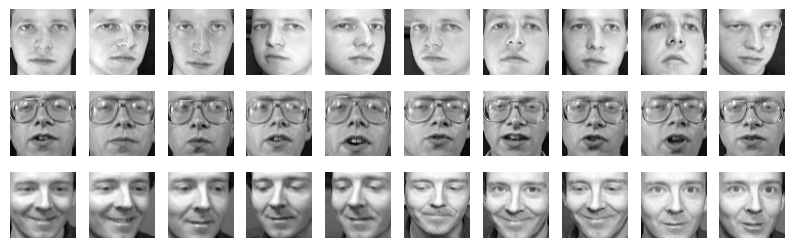

In [15]:
# Here are the first ten guys of the dataset
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    
    ax.imshow(D[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

    

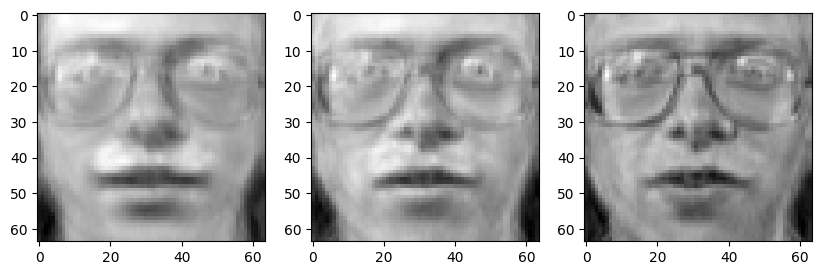

In [74]:

# D = data matrix
def PCA(D,r):
    # For each row, collect the means and subtract them from their respective rows
    mu_F = D.mean(axis=1).reshape(-1, 1)
    C = D-mu_F
    # Randomized SVD functions returns a transposed V
    U, Sigma, VT = randomized_svd(D, r)
    return C@VT.T, [U, Sigma, VT], mu_F

pca25, trsvd25, mu_F = PCA(D,25)
pca50, trsvd50, mu_F = PCA(D,50)
pca100, trsvd100, mu_F = PCA(D,100)

image25 = pca25[19]@trsvd25[2] + mu_F[1]
image50 = pca50[19]@trsvd50[2] + mu_F[1]
image100 = pca100[19]@trsvd100[2] + mu_F[1]

fig = plt.figure(figsize=(10, 3))

plt.subplot2grid((1,3), (0,0)).imshow(image25.reshape(64,64), cmap=plt.cm.gray)
plt.subplot2grid((1,3), (0,1)).imshow(image50.reshape(64,64), cmap=plt.cm.gray)
plt.subplot2grid((1,3), (0,2)).imshow(image100.reshape(64,64), cmap=plt.cm.gray)



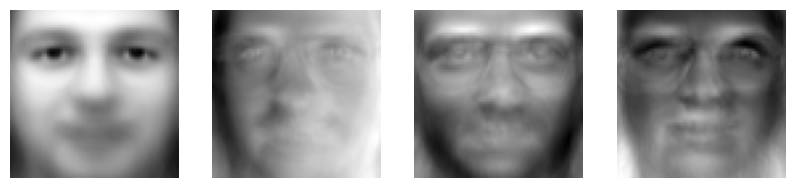

In [78]:
fig = plt.figure(figsize=(10, 3))
for i in range(4):
    x = plt.subplot2grid((1, 4), (int(i/4), i-int(i/4)*4))
    x.imshow(trsvd100[2][i].reshape(64, 64), cmap=plt.cm.gray)
    x.axis('off')


# Exercise: k-means Initialization

In [16]:
!pip3 show scikit-learn

Name: scikit-learn
Version: 1.2.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /home/jesse/.local/lib/python3.10/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 


In [17]:
!pip3 show numpy

Name: numpy
Version: 1.24.1
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /home/jesse/.local/lib/python3.10/site-packages
Requires: 
Required-by: contourpy, matplotlib, pandas, scikit-learn, scipy, seaborn, torchvision


If your versions don't match, the following commands (or their anaconda version) could help to get the newest stable release. If you need help with this, please ask the TAs during instruction hours.

In [18]:
!pip3 install scikit-learn --upgrade
!pip3 install numpy --upgrade

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


The functions generating the datasets are given here:

In [19]:
def generateMoons(epsilon, n):
    moons, labels = sklearn.datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    return "moons", moons, labels, 2
def generateBlobs(epsilon, n):
    blobs, labels = sklearn.datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 2.5, epsilon + 0.5])
    return "blobs", blobs, labels, 3

Extra function needed

In [20]:
def computeP(D,X):
    n = D.shape[0]
    P = np.zeros(n)
    denominator = np.sum([np.linalg.norm(D[j,:].T - X) for j in range(n)])
    for i in range(n):
        P[i] = np.linalg.norm(D[i,:].T - X) / denominator
    return P

In [21]:
def computeI(D,X,l,i_list):
    dist_list=[]
    for i in i_list:
        minus_term = np.concatenate(X,D[i,:].T)
        sum = np.sum([np.linalg.norm(D[j,:].T - minus_term) for j in range(n)])
        dist_list.append(sum)
    return 0

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [22]:
def init_centroids_greedy_pp(D,r,l=10):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :param l: (int) number of centroid candidates in each step
        :return: (np-array) 'X' the selected centroids from the dataset
    '''   
    rng =  np.random.default_rng(seed=7) # use this random generator to sample the candidates (sampling according to given probabilities can be done via rng.choice(..))
    n,d = D.shape

    indexes = rng.integers(low=0, high=n, size=r)
    X = np.array(D[indexes,:]).T
    s = 2
    while s <= r:
        P = computeP(D,X)
        i_list = np.random.choice(n, size=l, p=P, replace=False)
        i = np.argmin(computeI)
        X = np.hstack((X, D[i, :].reshape(d, 1)))
        s += 1
    return X

In [23]:
init_centroids_greedy_pp(D, r = 2)

ValueError: operands could not be broadcast together with shapes (4096,) (4096,2) 

In [ ]:
import scipy
def spectral_clustering(W,r, X_init):
    '''
        :param W: (np-array) nxn similarity/weighted adjacency matrix
        :param r: (int) number of centroids (clusters)
        :param X_init: (function) the centroid initialization function 
        :return: (np-array) 'Y' the computed cluster assignment matrix
    '''
    L = np.diag(np.array(W.sum(0))[0]) - W
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM")
    A = V[:,1:]
    initial_points = X_init(A,r)
    X, Y = kmeans(A, r, initial_points)
    return Y

This is the $k$-means implementation from the lecture accompanying notebook.

In [ ]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)

In [ ]:
def getY(labels):
    '''
        Compute the cluster assignment matrix Y from the categorically encoded labels
    '''
    Y = np.eye(max(labels)+1)[labels]
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum((np.expand_dims(D,2) - X)**2,1)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

We generate a dataset.

In [ ]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)

NameError: name 'generateBlobs' is not defined

Run kmeans and spectral clustering based on the initialization technique.

In [ ]:
X_init = init_centroids_greedy_pp(D,r)
X,Y = kmeans(D,r, X_init)

NameError: name 'D' is not defined

Plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. You can use this visualization to see if your initialization makes sense. It doesn't work for spectral clustering.

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
ax.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

We generate the moons dataset and compute spectral clustering with the implemented initialization technique.

In [ ]:
dataID, D, labels, r = generateMoons(0.05,n)

NameError: name 'generateMoons' is not defined

In [ ]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph
# Implement here the computation of W as knn graph
W = radius_neighbors_graph(D,0.5,include_self=False)
Y = spectral_clustering(W,r,init_centroids_greedy_pp)

plt.scatter(D[:, 0], D[:, 1], c=np.argmax(Y,axis=1), s=10)
plt.title('%s'  % ( dataID) )
plt.show()

NameError: name 'D' is not defined

In [ ]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_grap
X,Y = kmeans(D,r, X_init)
N = kneighbors_graph(D, n_neighbors=20,include_self=False, n_jobs=-1)
W = 0.5*(N+N.T)
spectral_clustering(W,r,X_init)

ImportError: cannot import name 'kneighbors_grap' from 'sklearn.neighbors' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\__init__.py)

### Therefore, the answer for 3-a is D

# Exercise : Movielens
To read the dataset you might need to alter the path to look for it:

In [25]:
# lets explore movies.csv
import pandas as pd
movies= pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
# lets explore ratings.CSV
ratings=pd.read_csv('ratings.csv',sep=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The original ratings are in the range of 0.5 and 5:

In [28]:
min(ratings["rating"]), max(ratings["rating"])

(0.5, 5.0)

We convert the sparse representation of movie ratings into a data matrix. The missing values are filled with zeros.

In [29]:
df_movie_ratings = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  #fill unobserved entries with μ
df_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We consider here only the movies which have been rated by more than 200 users. That are 18 movies. We will not be able to infer a pattern for movies with very few observations anyways, but for this exercise we are mostly interested in the prnciple and do not need a big dataset.

In [30]:
np.sum(np.sum(df_movie_ratings!=0,0)>200)

18

In [31]:
keep_movie = np.sum(df_movie_ratings!=0,0)>200
df_D = df_movie_ratings.loc[:,keep_movie]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Furthermore, we will throw out all the users which have not rated more than five movies.

In [32]:
np.sum(np.sum(df_D!=0,1)>5)

344

The resulting dataset has the userID as rows and movieIDs as columns. Hence, userID 1 and 4 addresses the first two rows of this dataset.

In [33]:
keep_user = np.sum(df_D!=0,1)>5
df_D = df_D.loc[keep_user,:]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,1.0,5.0,4.0,0.0,2.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0
7,4.5,0.0,4.5,0.0,4.5,5.0,0.0,0.0,5.0,5.0,0.0,2.5,5.0,4.5,4.0,0.0,4.0,0.0


The movie number- title assignments are given as follows:

In [34]:
movies.loc[movies['movieId'].isin(df_D.columns)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


The resulting data matrix is given as follows:

In [35]:
D = df_D.to_numpy()
D.shape

(344, 18)

In [36]:
def indNonzero(D,n,m):
    O = np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if D[i][j] != 0:
                O[i][j] = 1
    return O

In [37]:
def initalizeMatrix(n,m,r):
    X = np.random.rand(m, r)
    Y = np.random.rand(n, r)
    return X,Y

In [38]:
def computeXk(D,k,O_xk,X,Y,l,d,r):
    D_kT = D[:,k].T
    inverse = np.linalg.inv(Y.T@O_xk@Y+l*np.eye(r))
    X[k,:] = D_kT@Y@inverse
    return X

In [39]:
def computeYi(D,i,O_yi,X,Y,l,n,r):
    D_iT = D[i,:].T
    inverse = np.linalg.inv(X.T@O_yi@X+l*np.eye(r))
    Y[i,:] = D_iT@X@inverse
    return Y

# Question 4

### Question A

In [66]:
from copy import deepcopy

mseo = []
mseo_early_stopping = []

def completionOfMatrix(D,r,t_max,l):
    early_stopped = False
    early_epoch = 1
    n = D.shape[0]
    d = D.shape[1]
    relative_change_threshold = 0.0001
    relative_change = 1
    X,Y = initializeMatrix(n,d,r) 
    O = indNonzero(D,n,d)
    card_O = O.shape[0]
    t = 1
    while t < t_max:
        for k in range(d):
            O_xk = np.diagflat(O[:,k])
            X = computeXk(D,k,O_xk,X,Y,l,d,r)
            for i in range(n):
                O_yi = np.diagflat(O[i,:])
                Y = computeYi(D,i,O_yi,X,Y,l,n,r)
        MSEO = 1/card_O * np.linalg.norm(D - O*(Y@X.T))**2
        mseo.append(MSEO)
        
        # Early stopping
        if t > 1:
            relative_change = abs(MSEO - mseo[-2])
        if (relative_change>relative_change_threshold) and early_epoch == 1:
            early_epoch = t
        if not early_stopped and relative_change < relative_change_threshold:
            early_stopped = True
            print("Early stopping would have triggered at epoch ", t)
            mseo_early_stopping = deepcopy(mseo)

        t += 1
    return X,Y,early_epoch

X,Y,early_epoch = completionOfMatrix(D,r=5,t_max=100,l = 0.0001)

Text(0.5, 1.0, 'MSEO-Epoch graph')

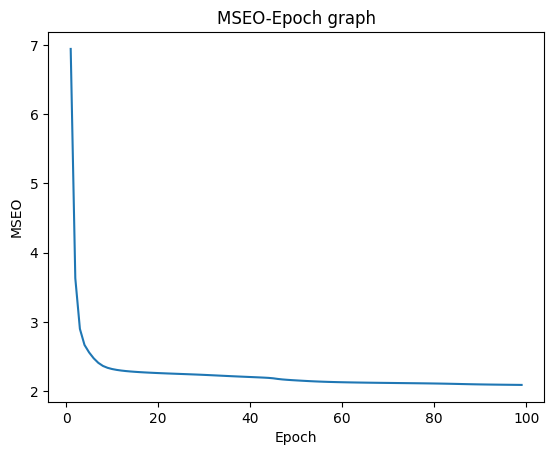

In [67]:
x_axis_labels = [i for i in range(1, len(mseo)+1)]
plt.plot(x_axis_labels, mseo)
plt.xlabel('Epoch')
plt.ylabel('MSEO')
plt.title('MSEO-Epoch graph')

### Question B

Theory question, personally no clue.

### Answer: Threshold that is early stopped, change vales to observe which one

Solution for Question D

In [69]:
selected_batch = pd.DataFrame(D[:3])
selected_batch

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
1,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
2,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### Answer: Approximation for multiple, different lambda types

In [70]:
selected_batch = pd.DataFrame(D[:3])
selected_batch

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
1,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
2,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
def approximator(df):
    df = np.round(df, 0)
    return pd.DataFrame(df)

In [72]:
lambdas = [1, 0.5, 0.1, 0.0001]
results = {}
for i in lambdas:
    X,Y,early_epoch = completionOfMatrix(D,r=5,t_max=100,l = i)
    matrix = pd.DataFrame(Y[:3]@X.T)
    print(f"Lambda: {i}")
    display(approximator(matrix))

Early stopping would have triggered at epoch  82
Lambda: 1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0,3.0,5.0,5.0,5.0,4.0
1,6.0,2.0,4.0,1.0,5.0,5.0,2.0,6.0,5.0,2.0,8.0,1.0,5.0,3.0,5.0,1.0,5.0,2.0
2,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0


Early stopping would have triggered at epoch  90
Lambda: 0.5


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,4.0,3.0,5.0,5.0,5.0,4.0
1,8.0,2.0,4.0,2.0,8.0,5.0,2.0,7.0,8.0,3.0,10.0,1.0,5.0,5.0,5.0,1.0,5.0,2.0
2,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0


Early stopping would have triggered at epoch  87
Lambda: 0.1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,5.0,4.0,5.0,4.0
1,4.0,3.0,4.0,-1.0,3.0,5.0,2.0,2.0,1.0,1.0,5.0,1.0,4.0,-0.0,5.0,1.0,5.0,2.0
2,4.0,4.0,4.0,3.0,3.0,4.0,5.0,4.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,4.0


Lambda: 0.0001


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,5.0,5.0,5.0,5.0
1,18.0,2.0,5.0,4.0,5.0,5.0,2.0,10.0,5.0,4.0,9.0,4.0,5.0,39.0,5.0,1.0,5.0,1.0
2,4.0,5.0,5.0,4.0,3.0,-2.0,5.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,-2.0,5.0,6.0,6.0


# Notes

### Question 1

Options:
- A. Using the default hyper-parameters, the model generalizes well since the accuracy on the test set is higher than the accuracy on the validation set.
- B. Using the default hyper-parameters, the model suffers from underfitting.
- C. Using a dropout of 0.5 reduces overfitting.
- D. Using L2 regularization of 0.05 reduces underfitting.

Elimination:
- B. Just no. The standard tuning results in 100% train accuracy and 96% test accuracy. There's definitely no underfitting.
- A. Fun fact, the accuracy on the test set is actually lower than the accuracy on the validation set if you calculate them. Contradiction.
- D. Cannot be. The only thing L2 regularization reduces is fitting. The accuracy drops massively compared to other tunings. Underfitting is a scenario where a model doesn't capture the relationship. L2 only seems to inspire underfitting.

C seems likely. The normal tuning is 100% accurate on the training set while the dropout version isn't. However, it's test accuracy is slightly improved. Thus, sure. It seems to generalize better.